# TPM034A Machine Learning for socio-technical systems 
## `Assignment 01: Discover, explore and visualise data`

**Delft University of Technology**<br>
**Q2 2022**<br>
**Instructor:** Sander van Cranenburgh <br>
**TAs:**  Francisco Garrido Valenzuela & Lucas Spierenburg <br>

### `Instructions`

**Assignments aim to:**<br>
* Examine your understanding of the key concepts and techniques.
* Examine your the applied ML skills.

**Assignments:**<br>
* Are graded and must be submitted (see the submission instruction below). 

### `Workspace set-up`
**Option 1: Google Colab**<br>
Uncomment the following cells code lines if you are running this notebook on Colab

In [1]:
#!git clone https://github.com/TPM34A/Q2_2022
#!pip install -r Q2_2022/requirements_colab.txt
#!mv "/content/Q2_2022/Assignments/assignment_01/data" /content/data

**Option 2: Local environment**<br>
Uncomment the following cell if you are running this notebook on your local environment. This will install all dependencies on your Python version.

In [2]:
#!pip install -r requirements.txt

## `Application: Liveability and affordable housing in Amsterdam` <br>

### **Introduction**
There is a widespread sense that affordable housing for the middle incomes households is under pressure. Especially for new entrants to the housing markets (i.e. those who do not yet own a house), affordable houses to buy in pleasant neighboorhoods are in short supply. Entrants to the housing market typically are people in their 20s and 30s.<br>

The municipality of Amsterdam would like to tackle this issue. (see https://openresearch.amsterdam/en/page/77950/housing-crisis for articles on the subject). However, at present, the municipality of Amsterdam lacks insights on the extent to which access to affordable houses has deteriorated. <br>

*Your are asked to assist the municipality of Amsterdam in investigating **whether** and **where** access to afforable houses has deteriorated.*<br>

### **Data**

You have access to four data sets:
1. Real-estate prices in Amsterdam, at buurt level
1. Liveability scores in the Netherlands, at buurt level
1. Population statistics in the Netherlands, at buurt level
1. Buurten boundaries in the Netherlands (GIS)

### **Notes**
- In the livability scores dataset the column *versie* show the different versions of the livability score, only use the 3rd version. Thus, you may filter this column to keep *Leefbaarometer 3.0*	only.
- You may assume that the population statistics and geospatial data have not substantially changed across the years 2014 and 2020. Thus, you may assume both apply to 2014 and 2020.
- For Population statistics (3rd dataset), [this document](data/buurt/metadata_buurt.csv) provides a brief explanation of the features.

### **Tasks and grading**

Your assigment is divided into 3 subtasks: (1) Data preparation, (2) Data exploration and (3) Assess the affordability of liveable neighborhoods. In total, 10 points can be earned in this assignment. The weight per subtask is shown below. 

1.  **Data preparation: construct data from multiple data sources.** [2 pnt]
    1. Load the four dataset and show a preview of the dataset structure (some DataFrame rows).
    1. Prepare the table data (non-GIS) to have two different DataFrames (for 2014 and 2020) that contains the following information:
        - the liveability data for the year of interest, using the 3rd version of the Leefbaarometer
        - population data 
        - Real-estate prices
        - at the buurt level
        - *Make sure to filter the data and remove NULL (NaN values) if required*
    1. Add the geographic component of the buurten to your data.
1. **Data exploration: discover and visualise data.** [4 pnt]
    1.  Investigate the statistical distribution of the real-estate price levels and liveability in both years, using either a histogram of a CDF.
    1. Visualise the correlation between real-estate prices and liveability in Amsterdam, at the buurt level, with a scatter plot for each year. Then, visualise spatially real-estate prices and liveability in Amsterdam for 2014 and 2020 (use the same color scale for years 2014 and 2020).
1. **Assess the change in affordability of liveable neighbourhoods.** [3 pnt]
    1. Explore how the change in liveability associates with a change in real-estate prices, using a scatter plot.
    1. Compute the ratio of the liveability score over the real-estate price for both years, and show how the distribution of the ratio of liveability over real-estate price has changed between the two years.
    1. Determine the 5 buurten in which the ratio of liveability over real-estate has deteriorated most.
    1. Determine whether the number of buurten with price < 5k euro/m2 and a liveability ratio > 1/k euro has decreased in 2020, compared to 2014
1. **Qualitative reflection on machine learning and generalisation: There are some buurts in Amsterdam for which real-estate price data were missing. Suppose the minicipality of Amsterdam asks you whether you can create a machine learning model that can predict real-estate prices from the liveability index. Do you think this is possible? Explain your answer (conceptually).** [1 pnt]

### **Submission**
- The deadline for this assignment is **Wed, 23 November 2022** 
- Use **Python 3.7 or above**
- You have to submit your work in zip file with the ipynb (fully executed) in brightspace

In [3]:
#import the required packages and modules 
import os
from os import getcwd
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.api import OLS, add_constant, tools
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100) #set to 100 to show all nan values within the final dataframes 

### 1. Data preparation: construct data from multiple data sources [2 pnt]
#### 1.1 Load the four dataset and show a preview of the dataset structure (some DataFrame rows).

In [4]:
# Load datasets 

#load csv files 
buurt_price    = pd.read_csv('data/real_estate_price/buurt_price.csv')
buurt_liv_data = pd.read_csv('data/liveability/buurt_liveability.csv')
buurt_pop      = pd.read_csv('data/buurt/buurt_2020_pop.csv')

#load shape file 
buurt_shape    = gpd.read_file('data/buurt/buurt 2020.shp')

Next, a preview of the datasets is shown by looking at the first 5 rows. For the population, the tail is also shown as the head has a lot of missing values. 

In [5]:
buurt_price.head()

,bu_code,price_2014,price_2020
0,BU03630000,3.594333,7.556500
1,BU03630001,4.313000,8.167375
2,BU03630002,3.851000,7.556500
3,BU03630003,4.867400,7.667400
4,BU03630004,4.813500,7.556500


In [6]:
print("\n The information in the liveability dataset is: \n",list(buurt_liv_data.keys()),'\n')

buurt_liv_data.head()


 The information in the liveability dataset is: 
 ['bu_code', 'versie', 'jaar', 'bu_naam', 'lbm', 'afw', 'fys', 'onv', 'soc', 'vrz', 'won'] 



,bu_code,versie,jaar,bu_naam,lbm,afw,fys,onv,soc,vrz,won
0,BU00030000,Leefbaarometer 1.0,2002,Appingedam-Centrum,4.105135,0.002870,NaN,NaN,NaN,NaN,NaN
1,BU00030000,Leefbaarometer 1.0,2008,Appingedam-Centrum,4.073118,-0.029147,NaN,NaN,NaN,NaN,NaN
2,BU00030000,Leefbaarometer 2.0,2012,Appingedam-Centrum,4.105344,0.003079,NaN,NaN,NaN,NaN,NaN
3,BU00030000,Leefbaarometer 3.0,2014,Appingedam-Centrum,4.139496,0.037231,0.030975,0.033936,0.013533,-0.072594,0.031381
4,BU00030000,Leefbaarometer 2.0,2016,Appingedam-Centrum,4.113966,0.011701,NaN,NaN,NaN,NaN,NaN


In [7]:
buurt_pop.head()

,BU_CODE,BU_NAAM,WK_CODE,GM_CODE,GM_NAAM,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,P_15_24_JR,P_25_44_JR,P_45_64_JR,P_65_EO_JR,P_WEST_AL,P_N_W_AL,P_MAROKKO,P_ANT_ARU,P_SURINAM,P_TURKIJE,P_OVER_NW,WONINGEN,P_1GEZW,P_MGEZW,P_BEWNDW,P_KOOPWON,P_HUURWON,P_HUURCORP,P_HUUROVVH,P_WONT2000,P_WONV2000,P_LEEGSW,WW_UIT_TOT,AUTO_HH,AV1_ARTSPR,AF_APOTH,AF_ZIEK_I,AV1_SUPERM,AV1_DAGLMD,AV1_CAFE,AF_WARENH,AV1_RESTAU,AF_HOTEL,AV1_KDV,AV1_BSO,AV1_ONDBAS,AF_ONDVRT,AF_ONDVMB,AF_ONDHV,AF_TREINST,AF_BIBLIO,AF_BIOS,AF_ATTRAC,AF_PODIUM,AF_MUSEUM
0,BU00109998,NaN,WK001099,GM0010,Delfzijl,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0
1,BU00349997,NaN,WK003499,GM0034,Almere,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0
2,BU00509997,NaN,WK005099,GM0050,Zeewolde,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0
3,BU00609998,NaN,WK006099,GM0060,Ameland,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0
4,BU00729998,NaN,WK007299,GM0072,Harlingen,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0


In [8]:
buurt_pop.tail() 

,BU_CODE,BU_NAAM,WK_CODE,GM_CODE,GM_NAAM,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,P_15_24_JR,P_25_44_JR,P_45_64_JR,P_65_EO_JR,P_WEST_AL,P_N_W_AL,P_MAROKKO,P_ANT_ARU,P_SURINAM,P_TURKIJE,P_OVER_NW,WONINGEN,P_1GEZW,P_MGEZW,P_BEWNDW,P_KOOPWON,P_HUURWON,P_HUURCORP,P_HUUROVVH,P_WONT2000,P_WONV2000,P_LEEGSW,WW_UIT_TOT,AUTO_HH,AV1_ARTSPR,AF_APOTH,AF_ZIEK_I,AV1_SUPERM,AV1_DAGLMD,AV1_CAFE,AF_WARENH,AV1_RESTAU,AF_HOTEL,AV1_KDV,AV1_BSO,AV1_ONDBAS,AF_ONDVRT,AF_ONDVMB,AF_ONDHV,AF_TREINST,AF_BIBLIO,AF_BIOS,AF_ATTRAC,AF_PODIUM,AF_MUSEUM
13898,BU19781901,Waal-Dorp,WK197819,GM1978,Molenlanden,2362,130,65,65,13,18,21,40,8,3,3,-99999999,-99999999,-99999999,-99999999,-99999999,41,100,0,100,93,5,0,5,83,17,0,0,-99999999.0,0.0,2.7,4.8,0.0,0.9,0.0,4.3,0.0,4.3,0.0,0.0,0.0,5.4,5.4,5.4,12.7,2.6,16.5,18.9,14.3,4.2
13899,BU19782001,Wijngaarden-Buitengebied,WK197820,GM1978,Molenlanden,2,10,5,5,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,1,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999.0,0.0,4.6,3.5,0.0,0.0,0.0,4.8,0.0,9.1,0.0,0.0,0.0,3.5,3.5,9.2,3.3,4.3,12.2,4.6,9.9,5.1
13900,BU19782002,Kern-Dorp,WK197820,GM1978,Molenlanden,3843,435,230,210,13,17,18,31,22,2,0,-99999999,-99999999,-99999999,-99999999,-99999999,183,98,2,97,76,23,20,3,84,16,3,10,1.2,0.0,4.1,3.4,0.0,0.0,0.0,4.7,0.0,6.3,1.0,0.0,1.0,4.2,4.2,6.4,3.2,3.7,9.4,2.5,7.0,4.5
13901,BU19782003,Lintbebouwing-Oost,WK197820,GM1978,Molenlanden,550,155,75,80,25,14,12,25,23,1,4,-99999999,-99999999,-99999999,-99999999,-99999999,42,100,0,95,90,10,2,7,86,14,5,0,-99999999.0,0.0,4.0,2.9,0.0,0.0,0.0,4.5,0.0,7.8,0.4,0.0,0.2,4.0,4.0,7.9,2.7,3.6,10.9,3.4,8.6,4.6
13902,BU19782004,Lintbebouwing-West,WK197820,GM1978,Molenlanden,583,110,60,50,17,14,16,29,25,0,0,-99999999,-99999999,-99999999,-99999999,-99999999,38,89,11,92,95,5,0,5,97,3,8,0,-99999999.0,0.0,4.7,4.2,0.0,0.0,0.0,5.6,0.0,5.3,0.2,0.0,0.5,4.9,4.9,5.4,4.1,4.6,8.4,3.4,6.1,5.4


In [9]:
buurt_shape.head()

,bu_code,bu_naam,gm_naam,geometry
0,BU00030000,Appingedam-Centrum,Appingedam,"POLYGON ((253552.594 594537.625, 253607.703 59..."
1,BU00030001,Appingedam-West,Appingedam,"POLYGON ((251866.000 594423.375, 252643.203 59..."
2,BU00030002,Appingedam-Oost,Appingedam,"POLYGON ((254580.774 594572.707, 254578.734 59..."
3,BU00030007,Verspreide huizen Damsterdiep en Eemskanaal,Appingedam,"POLYGON ((251082.797 593522.500, 251235.797 59..."
4,BU00030008,Verspreide huizen ten zuiden van Eemskanaal,Appingedam,"POLYGON ((254809.461 592701.710, 254809.858 59..."


#### 1.2 Prepare the table data (non-GIS) to have two different DataFrames (for 2014 and 2020) that contains the following information:
- the liveability data for the year of interest, using the 3rd version of the Leefbaarometer
- population data 
- Real-estate prices
- at the buurt level
- *Make sure to filter the data and remove NULL (NaN values) if required*

In [10]:
#Create a function to clean the liveability data 
def clean_liv_data(liv_data,year):

    # Remove rows where lbm is NaN
    liv_data.dropna(subset = ['lbm'], inplace = True)

    # Extract subsets: only year 2020 and 2014 and Leefbaarometer 3.0 data
    liv_data = liv_data.loc[(liv_data.versie ==  'Leefbaarometer 3.0') & (liv_data.jaar == year)]

    return liv_data

buurt_liv_data_2020 = clean_liv_data(buurt_liv_data, 2020)
buurt_liv_data_2014 = clean_liv_data(buurt_liv_data, 2014)

In [11]:
#check whether the liveability data is cleaned correctly 
buurt_liv_data_2014.head()

,bu_code,versie,jaar,bu_naam,lbm,afw,fys,onv,soc,vrz,won
3,BU00030000,Leefbaarometer 3.0,2014,Appingedam-Centrum,4.139496,0.037231,0.030975,0.033936,0.013533,-0.072594,0.031381
10,BU00030001,Leefbaarometer 3.0,2014,Appingedam-West,4.120090,0.017825,0.018875,0.063740,0.033912,-0.122080,0.023377
17,BU00030002,Leefbaarometer 3.0,2014,Appingedam-Oost,4.031258,-0.071007,0.030855,0.011637,-0.007610,-0.111561,0.005672
24,BU00030007,Leefbaarometer 3.0,2014,Verspr.h. Damsterdiep en Eemskanaal,4.244192,0.141927,0.007773,0.117398,0.092801,-0.161602,0.085557
31,BU00030008,Leefbaarometer 3.0,2014,Verspr.h. ten zuiden van Eemskanaal,4.259626,0.157361,-0.060387,0.130748,0.137032,-0.203840,0.153809


In [12]:
# Create a function to clean the population data by replacing the -99999999 data points with nan to make calculations easier later 
def clean_pop_data(pop_data):
    
    #make nan values of -99999999 values 
    pop_data = pop_data.replace([-99999999], float('nan'))
    
    return pop_data
    
buurt_pop_clean = clean_pop_data(buurt_pop)

In [13]:
#check whether the population data is cleaned correctly
buurt_pop_clean.head()

,BU_CODE,BU_NAAM,WK_CODE,GM_CODE,GM_NAAM,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,P_15_24_JR,P_25_44_JR,P_45_64_JR,P_65_EO_JR,P_WEST_AL,P_N_W_AL,P_MAROKKO,P_ANT_ARU,P_SURINAM,P_TURKIJE,P_OVER_NW,WONINGEN,P_1GEZW,P_MGEZW,P_BEWNDW,P_KOOPWON,P_HUURWON,P_HUURCORP,P_HUUROVVH,P_WONT2000,P_WONV2000,P_LEEGSW,WW_UIT_TOT,AUTO_HH,AV1_ARTSPR,AF_APOTH,AF_ZIEK_I,AV1_SUPERM,AV1_DAGLMD,AV1_CAFE,AF_WARENH,AV1_RESTAU,AF_HOTEL,AV1_KDV,AV1_BSO,AV1_ONDBAS,AF_ONDVRT,AF_ONDVMB,AF_ONDHV,AF_TREINST,AF_BIBLIO,AF_BIOS,AF_ATTRAC,AF_PODIUM,AF_MUSEUM
0,BU00109998,NaN,WK001099,GM0010,Delfzijl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BU00349997,NaN,WK003499,GM0034,Almere,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BU00509997,NaN,WK005099,GM0050,Zeewolde,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BU00609998,NaN,WK006099,GM0060,Ameland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BU00729998,NaN,WK007299,GM0072,Harlingen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# merge the population, real estate price and liveability dataframes 
buurt_pop_clean = buurt_pop_clean.rename(columns={"BU_CODE": "bu_code"}) #rename the bu_code column to make merging possible 
buurt_pop_clean = buurt_pop_clean.drop(columns = ['BU_NAAM']) #Drop columns to prevent duplicate columns

buurt_2014_nopop = buurt_liv_data_2014.merge(buurt_price[['bu_code','price_2014']], on ="bu_code", how = "inner")
buurt_2014 = buurt_2014_nopop.merge(buurt_pop_clean , on ="bu_code", how = "inner")

buurt_2020_nopop = buurt_liv_data_2020.merge(buurt_price[['bu_code','price_2020']], on ="bu_code", how = "inner")
buurt_2020 = buurt_2020_nopop.merge(buurt_pop_clean , on ="bu_code", how = "inner")

In [15]:
#Look at the 2014 dataframe 
buurt_2014.tail()

,bu_code,versie,jaar,bu_naam,lbm,afw,fys,onv,soc,vrz,won,price_2014,WK_CODE,GM_CODE,GM_NAAM,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,P_15_24_JR,P_25_44_JR,P_45_64_JR,P_65_EO_JR,P_WEST_AL,P_N_W_AL,P_MAROKKO,P_ANT_ARU,P_SURINAM,P_TURKIJE,P_OVER_NW,WONINGEN,P_1GEZW,P_MGEZW,P_BEWNDW,P_KOOPWON,P_HUURWON,P_HUURCORP,P_HUUROVVH,P_WONT2000,P_WONV2000,P_LEEGSW,WW_UIT_TOT,AUTO_HH,AV1_ARTSPR,AF_APOTH,AF_ZIEK_I,AV1_SUPERM,AV1_DAGLMD,AV1_CAFE,AF_WARENH,AV1_RESTAU,AF_HOTEL,AV1_KDV,AV1_BSO,AV1_ONDBAS,AF_ONDVRT,AF_ONDVMB,AF_ONDHV,AF_TREINST,AF_BIBLIO,AF_BIOS,AF_ATTRAC,AF_PODIUM,AF_MUSEUM
373,BU03639701,Leefbaarometer 3.0,2014,Gein Zuidwest,3.778805,-0.323459,0.017618,-0.160912,-0.072880,-0.012445,-0.094840,2.002000,WK036397,GM0363,Amsterdam,9641.0,1685.0,815.0,870.0,19.0,13.0,34.0,28.0,7.0,10.0,71.0,2.0,4.0,29.0,1.0,35.0,748.0,0.0,100.0,99.0,24.0,76.0,56.0,20.0,100.0,0.0,1.0,50.0,0.5,1.3,0.7,3.2,0.7,3.9,0.0,4.4,1.4,3.4,5.2,1.0,3.3,1.3,1.3,1.3,2.8,1.3,5.1,1.7,4.1,8.0
374,BU03639702,Leefbaarometer 3.0,2014,Gein Noordoost,3.929033,-0.173232,0.014353,-0.015562,0.009483,-0.040211,-0.141295,2.296136,WK036397,GM0363,Amsterdam,5134.0,3265.0,1645.0,1615.0,14.0,12.0,21.0,34.0,18.0,15.0,34.0,0.0,1.0,18.0,1.0,14.0,1261.0,100.0,0.0,98.0,96.0,4.0,0.0,4.0,100.0,0.0,2.0,50.0,1.0,0.5,1.0,3.5,0.4,2.1,0.0,4.9,0.4,3.2,3.1,0.8,1.9,1.8,1.8,1.8,3.1,2.0,5.3,0.7,4.0,7.7
375,BU03639703,Leefbaarometer 3.0,2014,Gein Zuidoost,3.811861,-0.290404,0.007600,-0.089439,-0.053350,-0.042289,-0.112927,2.156125,WK036397,GM0363,Amsterdam,4703.0,3370.0,1640.0,1730.0,15.0,10.0,27.0,30.0,18.0,11.0,51.0,2.0,4.0,25.0,1.0,19.0,1557.0,56.0,44.0,94.0,23.0,77.0,54.0,23.0,100.0,0.0,6.0,70.0,0.7,0.9,0.9,3.4,0.6,3.4,0.1,4.6,1.2,3.6,3.9,0.5,2.8,1.5,1.5,1.5,3.0,1.6,5.3,1.6,4.3,8.1
376,BU03639800,Leefbaarometer 3.0,2014,Dorp Driemond,4.024627,-0.077638,-0.018303,0.033241,0.011090,-0.039796,-0.063870,2.895800,WK036398,GM0363,Amsterdam,5119.0,1490.0,705.0,785.0,18.0,12.0,22.0,31.0,19.0,10.0,12.0,1.0,1.0,5.0,1.0,3.0,636.0,81.0,19.0,98.0,55.0,45.0,41.0,4.0,94.0,6.0,2.0,30.0,1.1,0.0,2.4,3.8,1.0,0.0,0.0,2.7,0.0,2.5,2.0,2.7,2.0,2.6,2.6,3.1,3.5,2.8,7.5,4.8,3.1,2.8
377,BU03639801,Leefbaarometer 3.0,2014,Landelijk gebied Driemond,4.414988,0.312723,-0.021303,0.110330,0.127837,-0.065963,0.161823,2.772500,WK036398,GM0363,Amsterdam,90.0,130.0,70.0,55.0,30.0,13.0,21.0,30.0,7.0,9.0,6.0,0.0,3.0,3.0,0.0,0.0,40.0,100.0,0.0,95.0,98.0,2.0,0.0,2.0,32.0,68.0,5.0,0.0,NaN,0.0,2.9,4.2,0.7,0.0,0.0,3.2,0.0,3.0,1.5,2.4,1.5,3.1,3.1,3.6,4.0,3.3,7.8,4.5,3.6,3.3


In [16]:
#Look at the 2020 dataframe 
buurt_2020.tail()

,bu_code,versie,jaar,bu_naam,lbm,afw,fys,onv,soc,vrz,won,price_2020,WK_CODE,GM_CODE,GM_NAAM,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,P_15_24_JR,P_25_44_JR,P_45_64_JR,P_65_EO_JR,P_WEST_AL,P_N_W_AL,P_MAROKKO,P_ANT_ARU,P_SURINAM,P_TURKIJE,P_OVER_NW,WONINGEN,P_1GEZW,P_MGEZW,P_BEWNDW,P_KOOPWON,P_HUURWON,P_HUURCORP,P_HUUROVVH,P_WONT2000,P_WONV2000,P_LEEGSW,WW_UIT_TOT,AUTO_HH,AV1_ARTSPR,AF_APOTH,AF_ZIEK_I,AV1_SUPERM,AV1_DAGLMD,AV1_CAFE,AF_WARENH,AV1_RESTAU,AF_HOTEL,AV1_KDV,AV1_BSO,AV1_ONDBAS,AF_ONDVRT,AF_ONDVMB,AF_ONDHV,AF_TREINST,AF_BIBLIO,AF_BIOS,AF_ATTRAC,AF_PODIUM,AF_MUSEUM
374,BU03639701,Leefbaarometer 3.0,2020,Gein Zuidwest,3.724199,-0.378066,0.015036,-0.208887,-0.070597,-0.008645,-0.104974,3.889833,WK036397,GM0363,Amsterdam,9641.0,1685.0,815.0,870.0,19.0,13.0,34.0,28.0,7.0,10.0,71.0,2.0,4.0,29.0,1.0,35.0,748.0,0.0,100.0,99.0,24.0,76.0,56.0,20.0,100.0,0.0,1.0,50.0,0.5,1.3,0.7,3.2,0.7,3.9,0.0,4.4,1.4,3.4,5.2,1.0,3.3,1.3,1.3,1.3,2.8,1.3,5.1,1.7,4.1,8.0
375,BU03639702,Leefbaarometer 3.0,2020,Gein Noordoost,3.987428,-0.114836,0.013961,-0.005415,0.004883,-0.019006,-0.109258,4.334500,WK036397,GM0363,Amsterdam,5134.0,3265.0,1645.0,1615.0,14.0,12.0,21.0,34.0,18.0,15.0,34.0,0.0,1.0,18.0,1.0,14.0,1261.0,100.0,0.0,98.0,96.0,4.0,0.0,4.0,100.0,0.0,2.0,50.0,1.0,0.5,1.0,3.5,0.4,2.1,0.0,4.9,0.4,3.2,3.1,0.8,1.9,1.8,1.8,1.8,3.1,2.0,5.3,0.7,4.0,7.7
376,BU03639703,Leefbaarometer 3.0,2020,Gein Zuidoost,3.835898,-0.266367,0.006972,-0.106834,-0.049448,-0.024901,-0.092155,3.834250,WK036397,GM0363,Amsterdam,4703.0,3370.0,1640.0,1730.0,15.0,10.0,27.0,30.0,18.0,11.0,51.0,2.0,4.0,25.0,1.0,19.0,1557.0,56.0,44.0,94.0,23.0,77.0,54.0,23.0,100.0,0.0,6.0,70.0,0.7,0.9,0.9,3.4,0.6,3.4,0.1,4.6,1.2,3.6,3.9,0.5,2.8,1.5,1.5,1.5,3.0,1.6,5.3,1.6,4.3,8.1
377,BU03639800,Leefbaarometer 3.0,2020,Dorp Driemond,4.091048,-0.011217,-0.018079,0.070203,0.004025,-0.027621,-0.039746,5.209563,WK036398,GM0363,Amsterdam,5119.0,1490.0,705.0,785.0,18.0,12.0,22.0,31.0,19.0,10.0,12.0,1.0,1.0,5.0,1.0,3.0,636.0,81.0,19.0,98.0,55.0,45.0,41.0,4.0,94.0,6.0,2.0,30.0,1.1,0.0,2.4,3.8,1.0,0.0,0.0,2.7,0.0,2.5,2.0,2.7,2.0,2.6,2.6,3.1,3.5,2.8,7.5,4.8,3.1,2.8
378,BU03639801,Leefbaarometer 3.0,2020,Landelijk gebied Driemond,4.249562,0.147297,0.001676,0.079847,0.060792,-0.045260,0.050241,4.334500,WK036398,GM0363,Amsterdam,90.0,130.0,70.0,55.0,30.0,13.0,21.0,30.0,7.0,9.0,6.0,0.0,3.0,3.0,0.0,0.0,40.0,100.0,0.0,95.0,98.0,2.0,0.0,2.0,32.0,68.0,5.0,0.0,NaN,0.0,2.9,4.2,0.7,0.0,0.0,3.2,0.0,3.0,1.5,2.4,1.5,3.1,3.1,3.6,4.0,3.3,7.8,4.5,3.6,3.3


In [17]:
#Identify the number of nan values for 2014, only the 20 columns with the highest missing values are shown
buurt_2014.isnull().sum().nlargest(20)

AUTO_HH       3
P_1GEZW       2
P_MGEZW       2
P_BEWNDW      2
P_KOOPWON     2
P_HUURWON     2
P_HUURCORP    2
P_HUUROVVH    2
P_WONT2000    2
P_WONV2000    2
P_LEEGSW      2
P_MAROKKO     1
P_ANT_ARU     1
P_SURINAM     1
P_TURKIJE     1
P_OVER_NW     1
bu_code       0
versie        0
jaar          0
bu_naam       0
dtype: int64

In [18]:
#Identify the number of nan values for 2020, only the 20 columns with the highest missing values are shown
buurt_2020.isnull().sum().nlargest(20)

AUTO_HH       3
P_1GEZW       2
P_MGEZW       2
P_BEWNDW      2
P_KOOPWON     2
P_HUURWON     2
P_HUURCORP    2
P_HUUROVVH    2
P_WONT2000    2
P_WONV2000    2
P_LEEGSW      2
P_MAROKKO     1
P_ANT_ARU     1
P_SURINAM     1
P_TURKIJE     1
P_OVER_NW     1
bu_code       0
versie        0
jaar          0
bu_naam       0
dtype: int64

Based on these missing values it is currently not necessary to filter or remove additional nan values 

#### 1.3 Add the geographic component of the buurten to your data

In [19]:
buurt_shape = buurt_shape.drop(columns = ['bu_naam', 'gm_naam']) #Drop columns to prevent duplicate columns

In [20]:
# Merge the GeoDataFrame and the DataFrames as previously constructed
buurt_2014_df = buurt_shape.merge(buurt_2014, on="bu_code")
buurt_2020_df = buurt_shape.merge(buurt_2020, on="bu_code")

In [21]:
print('The shape of the merged 2014 dataframe is:',buurt_2014_df.shape)
print('The shape of the merged 2020 dataframe is:',buurt_2020_df.shape)

The shape of the merged 2014 dataframe is: (378, 66)
The shape of the merged 2020 dataframe is: (379, 66)


In [22]:
#Check if the dataframes are made correctly 
buurt_2014_df.head()

,bu_code,geometry,versie,jaar,bu_naam,lbm,afw,fys,onv,soc,vrz,won,price_2014,WK_CODE,GM_CODE,GM_NAAM,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,P_15_24_JR,P_25_44_JR,P_45_64_JR,P_65_EO_JR,P_WEST_AL,P_N_W_AL,P_MAROKKO,P_ANT_ARU,P_SURINAM,P_TURKIJE,P_OVER_NW,WONINGEN,P_1GEZW,P_MGEZW,P_BEWNDW,P_KOOPWON,P_HUURWON,P_HUURCORP,P_HUUROVVH,P_WONT2000,P_WONV2000,P_LEEGSW,WW_UIT_TOT,AUTO_HH,AV1_ARTSPR,AF_APOTH,AF_ZIEK_I,AV1_SUPERM,AV1_DAGLMD,AV1_CAFE,AF_WARENH,AV1_RESTAU,AF_HOTEL,AV1_KDV,AV1_BSO,AV1_ONDBAS,AF_ONDVRT,AF_ONDVMB,AF_ONDHV,AF_TREINST,AF_BIBLIO,AF_BIOS,AF_ATTRAC,AF_PODIUM,AF_MUSEUM
0,BU03630000,"POLYGON ((121890.334 487818.898, 121957.841 48...",Leefbaarometer 3.0,2014,Kop Zeedijk,4.342111,0.239846,0.005343,-0.185291,-0.063916,0.483296,0.000414,3.594333,WK036300,GM0363,Amsterdam,18119.0,1100.0,625.0,470.0,4.0,11.0,52.0,25.0,7.0,36.0,18.0,0.0,1.0,2.0,1.0,12.0,773.0,4.0,96.0,79.0,20.0,78.0,7.0,71.0,96.0,4.0,21.0,20.0,0.2,6.6,0.3,1.1,10.6,140.7,181.2,0.5,295.7,0.0,6.9,4.0,2.2,1.1,1.1,1.1,0.4,0.8,1.2,1.1,0.6,0.2
1,BU03630001,"POLYGON ((121585.791 487654.680, 121624.240 48...",Leefbaarometer 3.0,2014,Oude Kerk e.o.,4.313165,0.210901,0.004292,-0.241124,-0.064267,0.507547,0.004453,4.313000,WK036300,GM0363,Amsterdam,8272.0,730.0,410.0,315.0,4.0,18.0,51.0,18.0,9.0,34.0,17.0,1.0,1.0,2.0,1.0,13.0,534.0,5.0,95.0,78.0,12.0,85.0,27.0,59.0,87.0,13.0,22.0,20.0,0.2,8.6,0.3,0.8,11.0,154.4,202.7,0.3,330.2,0.1,6.3,3.1,1.8,1.3,1.3,1.3,0.7,1.2,1.0,1.1,0.4,0.2
2,BU03630002,"POLYGON ((121799.802 487534.283, 121824.012 48...",Leefbaarometer 3.0,2014,Burgwallen Oost,4.275189,0.172924,0.002242,-0.235697,-0.087144,0.498839,-0.005316,3.851000,WK036300,GM0363,Amsterdam,25867.0,1610.0,855.0,755.0,5.0,16.0,48.0,19.0,11.0,34.0,20.0,1.0,1.0,2.0,1.0,15.0,1001.0,4.0,96.0,85.0,17.0,82.0,9.0,74.0,96.0,4.0,15.0,40.0,0.2,7.5,0.2,0.9,12.0,143.8,204.7,0.4,330.4,0.1,6.9,3.0,2.0,1.4,1.4,1.4,0.8,1.1,0.9,0.8,0.3,0.2
3,BU03630003,"POLYGON ((121345.067 487317.970, 121365.571 48...",Leefbaarometer 3.0,2014,Nes e.o.,4.418488,0.316223,0.037115,-0.217396,-0.041720,0.538209,0.000016,4.867400,WK036300,GM0363,Amsterdam,6565.0,350.0,195.0,155.0,5.0,17.0,51.0,20.0,7.0,38.0,12.0,0.0,0.0,1.0,2.0,8.0,263.0,9.0,91.0,71.0,29.0,70.0,5.0,65.0,98.0,2.0,29.0,10.0,0.3,8.5,0.3,0.7,13.3,160.8,228.4,0.2,375.3,0.1,6.4,2.8,2.1,1.4,1.7,1.4,1.0,1.6,0.6,1.0,0.1,0.2
4,BU03630004,"POLYGON ((121557.295 487212.269, 121595.682 48...",Leefbaarometer 3.0,2014,BG-terrein e.o.,4.420118,0.317854,0.014476,-0.187590,-0.056868,0.527690,0.020145,4.813500,WK036300,GM0363,Amsterdam,7960.0,670.0,370.0,300.0,5.0,19.0,43.0,22.0,12.0,28.0,14.0,1.0,1.0,2.0,1.0,9.0,400.0,7.0,93.0,85.0,21.0,78.0,36.0,42.0,100.0,0.0,15.0,10.0,0.2,7.5,0.4,0.8,12.9,149.7,228.0,0.3,370.2,0.1,6.6,3.4,2.3,1.5,1.8,1.5,1.1,1.5,0.5,0.8,0.2,0.3


In [23]:
#Identify the number of nan values 
buurt_2014_df.isnull().sum().nlargest(20)

AUTO_HH       3
P_1GEZW       2
P_MGEZW       2
P_BEWNDW      2
P_KOOPWON     2
P_HUURWON     2
P_HUURCORP    2
P_HUUROVVH    2
P_WONT2000    2
P_WONV2000    2
P_LEEGSW      2
P_MAROKKO     1
P_ANT_ARU     1
P_SURINAM     1
P_TURKIJE     1
P_OVER_NW     1
bu_code       0
geometry      0
versie        0
jaar          0
dtype: int64

Based on the number of missing datapoints as shown above it is not necessary to deal with missing data at this point. 

### 2. Data exploration: discover and visualise data [4 pnt]
#### 2.1 Investigate the statistical distribution of the real-estate price levels and liveability in both years

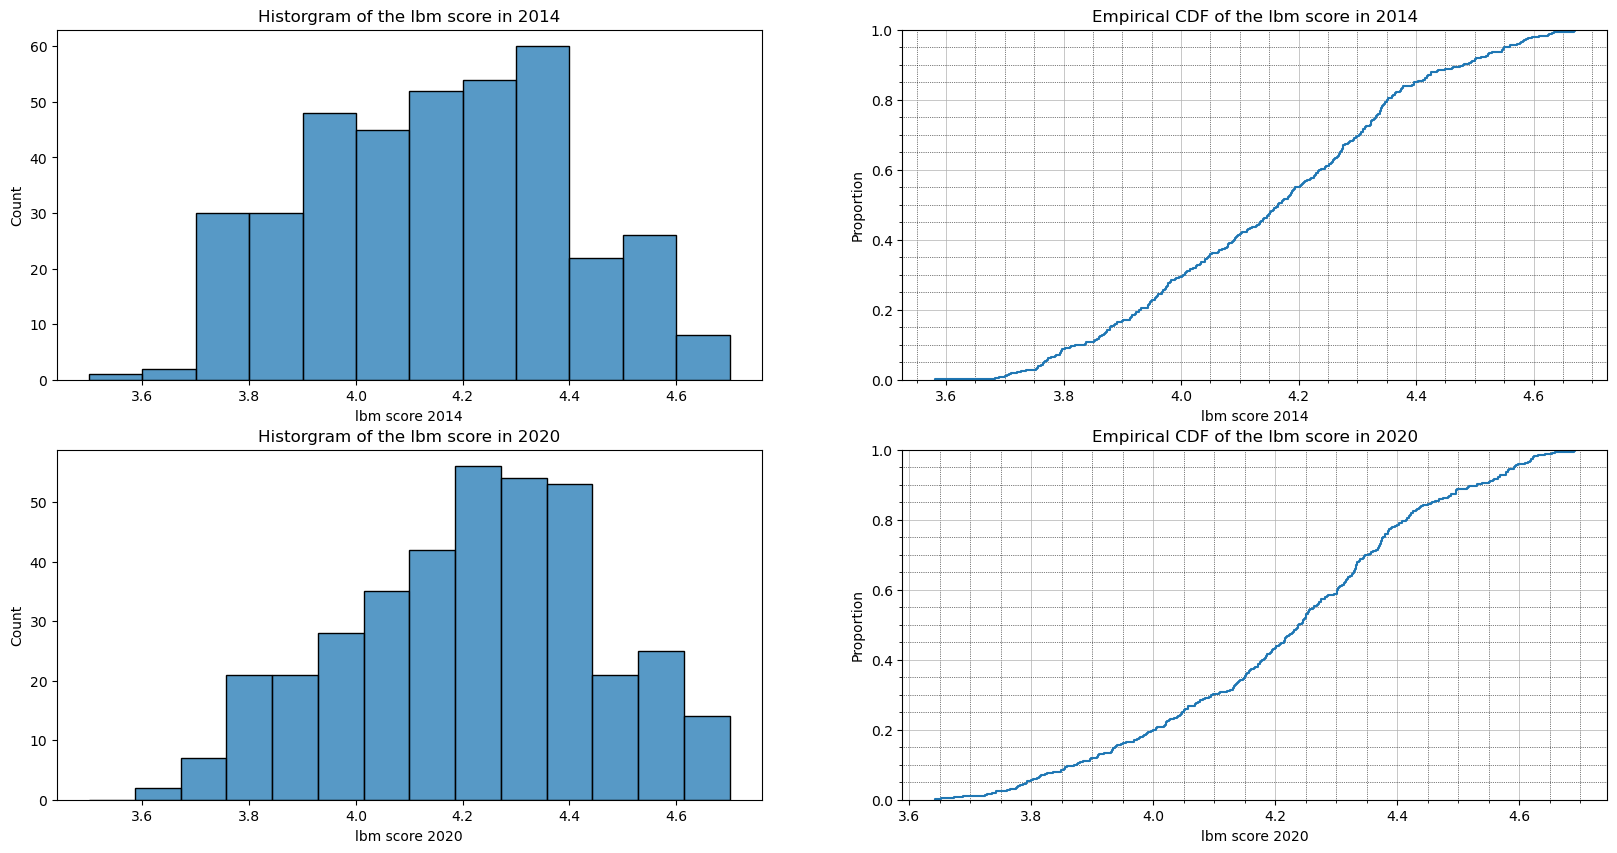

In [24]:
# Create a histogram and an empirical CDF for the liveability score for both years 
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=False)
sns.histplot(ax = axes[0,0],x = buurt_2014_df.lbm, binrange = (3.5,4.7))
ecdf_data = sns.ecdfplot(ax = axes[0,1],x = buurt_2014_df.lbm)
sns.histplot(ax = axes[1,0],x = buurt_2020_df.lbm, binrange = (3.5,4.7))
ecdf_data = sns.ecdfplot(ax = axes[1,1],x = buurt_2020_df.lbm)

axes[0,0].set_title("Historgram of the lbm score in 2014")
axes[0,0].set_xlabel("lbm score 2014")
axes[0,1].set_title("Empirical CDF of the lbm score in 2014")
axes[0,1].set_xlabel("lbm score 2014")
axes[0,1].grid(True,linewidth = 0.5)
axes[0,1].minorticks_on()
axes[0,1].grid(which='minor', linestyle=':', linewidth='0.5', color='black')

axes[1,0].set_title("Historgram of the lbm score in 2020")
axes[1,0].set_xlabel("lbm score 2020")
axes[1,1].set_title("Empirical CDF of the lbm score in 2020")
axes[1,1].set_xlabel("lbm score 2020")
axes[1,1].grid(True,linewidth = 0.5)
axes[1,1].minorticks_on()
axes[1,1].grid(which='minor', linestyle=':', linewidth='0.5', color='black')

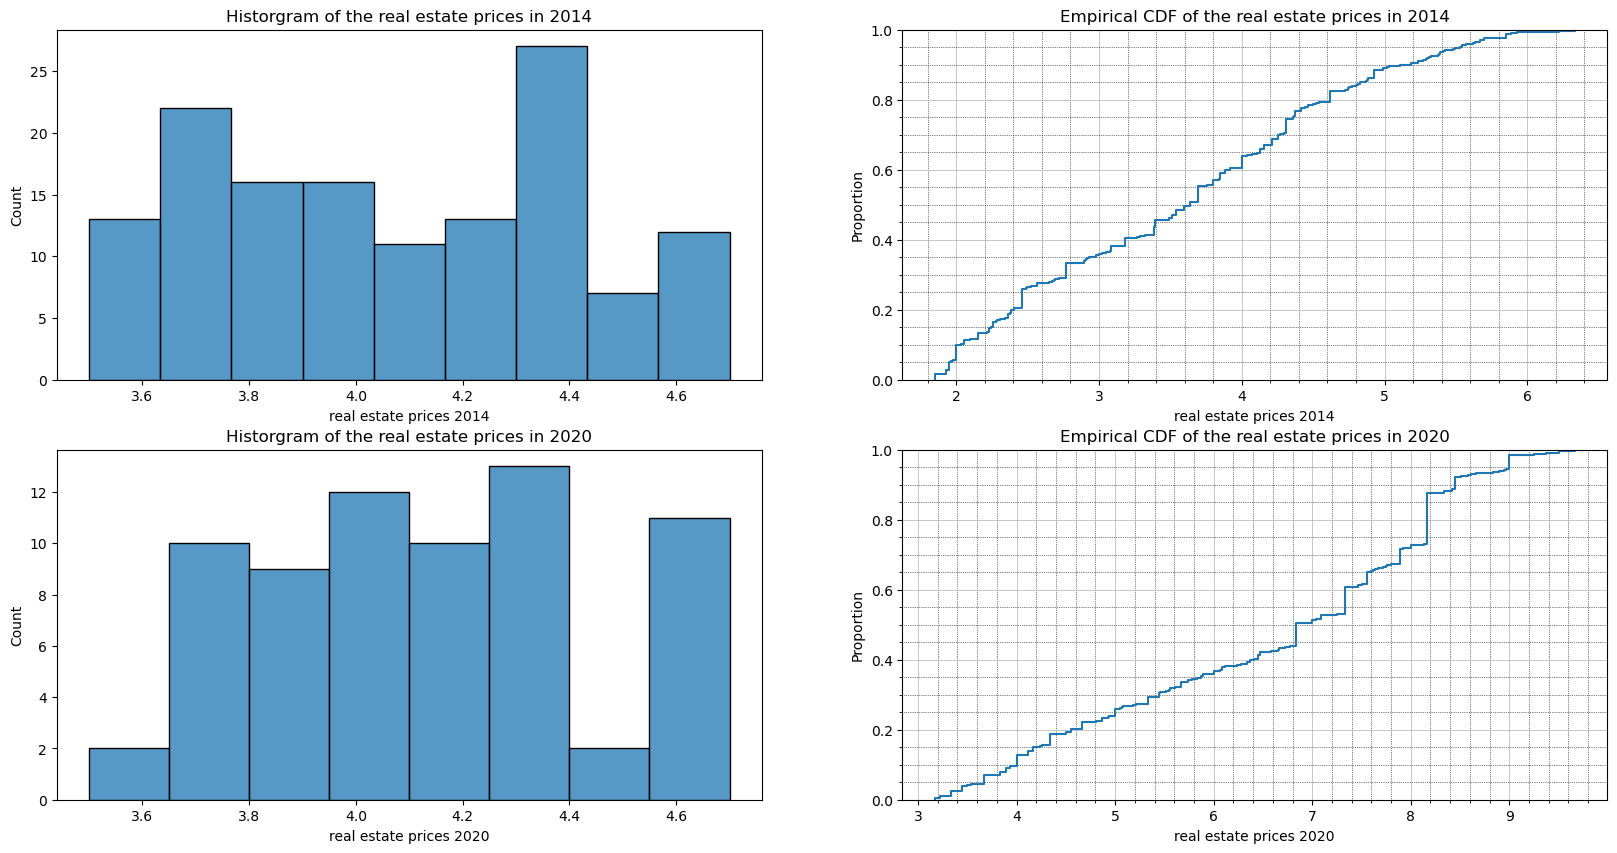

In [25]:
# Create a histogram and an empirical CDF for the real estate prices for both years 
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=False)
sns.histplot(ax = axes[0,0],x = buurt_2014_df.price_2014, binrange = (3.5,4.7))
ecdf_data = sns.ecdfplot(ax = axes[0,1],x = buurt_2014_df.price_2014)
sns.histplot(ax = axes[1,0],x = buurt_2020_df.price_2020, binrange = (3.5,4.7))
ecdf_data = sns.ecdfplot(ax = axes[1,1],x = buurt_2020_df.price_2020)

axes[0,0].set_title("Historgram of the real estate prices in 2014")
axes[0,0].set_xlabel("real estate prices 2014")
axes[0,1].set_title("Empirical CDF of the real estate prices in 2014")
axes[0,1].set_xlabel("real estate prices 2014")
axes[0,1].grid(True,linewidth = 0.5)
axes[0,1].minorticks_on()
axes[0,1].grid(which='minor', linestyle=':', linewidth='0.5', color='black')

axes[1,0].set_title("Historgram of the real estate prices in 2020")
axes[1,0].set_xlabel("real estate prices 2020")
axes[1,1].set_title("Empirical CDF of the real estate prices in 2020")
axes[1,1].set_xlabel("real estate prices 2020")
axes[1,1].grid(True,linewidth = 0.5)
axes[1,1].minorticks_on()
axes[1,1].grid(which='minor', linestyle=':', linewidth='0.5', color='black')

Text(0.5, 0, 'lbm values 2020')

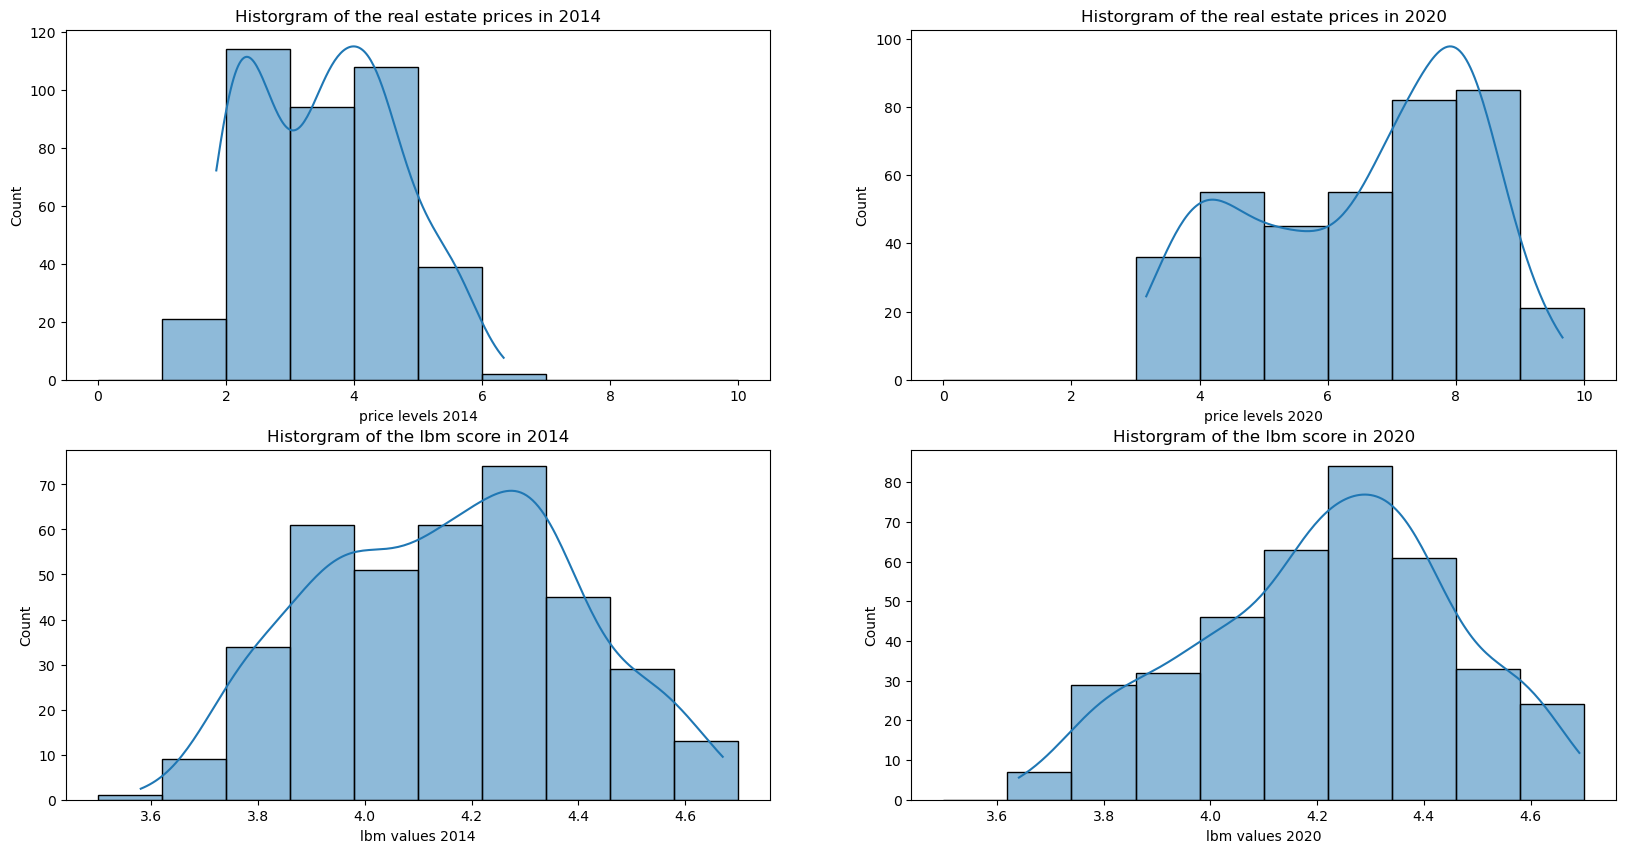

In [26]:
# Create histogram for 2014 and 2020 to compare the real estate price developments with the lbm scores 
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=False)
sns.histplot(ax = axes[0,0],x = buurt_2014_df.price_2014, bins = 10, kde=True, binrange = (0,10))
sns.histplot(ax = axes[0,1],x = buurt_2020_df.price_2020, bins = 10, kde=True, binrange = (0,10))

sns.histplot(ax = axes[1,0],x = buurt_2014_df.lbm, bins = 10, kde=True, binrange = (3.5,4.7))
sns.histplot(ax = axes[1,1],x = buurt_2020_df.lbm, bins = 10, kde=True, binrange = (3.5,4.7))

axes[0,0].set_title("Historgram of the real estate prices in 2014")
axes[0,0].set_xlabel("price levels 2014")
axes[0,1].set_title("Historgram of the real estate prices in 2020")
axes[0,1].set_xlabel("price levels 2020")
axes[1,0].set_title("Historgram of the lbm score in 2014")
axes[1,0].set_xlabel("lbm values 2014")
axes[1,1].set_title("Historgram of the lbm score in 2020")
axes[1,1].set_xlabel("lbm values 2020")

#### 2.2 Visualise the correlation between real-estate prices and liveability in Amsterdam, at the buurt level, with a scatter plot for each year. Then, visualise spatially real-estate prices and liveability in Amsterdam for 2014 and 2020 (use the same color scale for years 2014 and 2020).

Text(0, 0.5, 'Liveability scores in 2020')

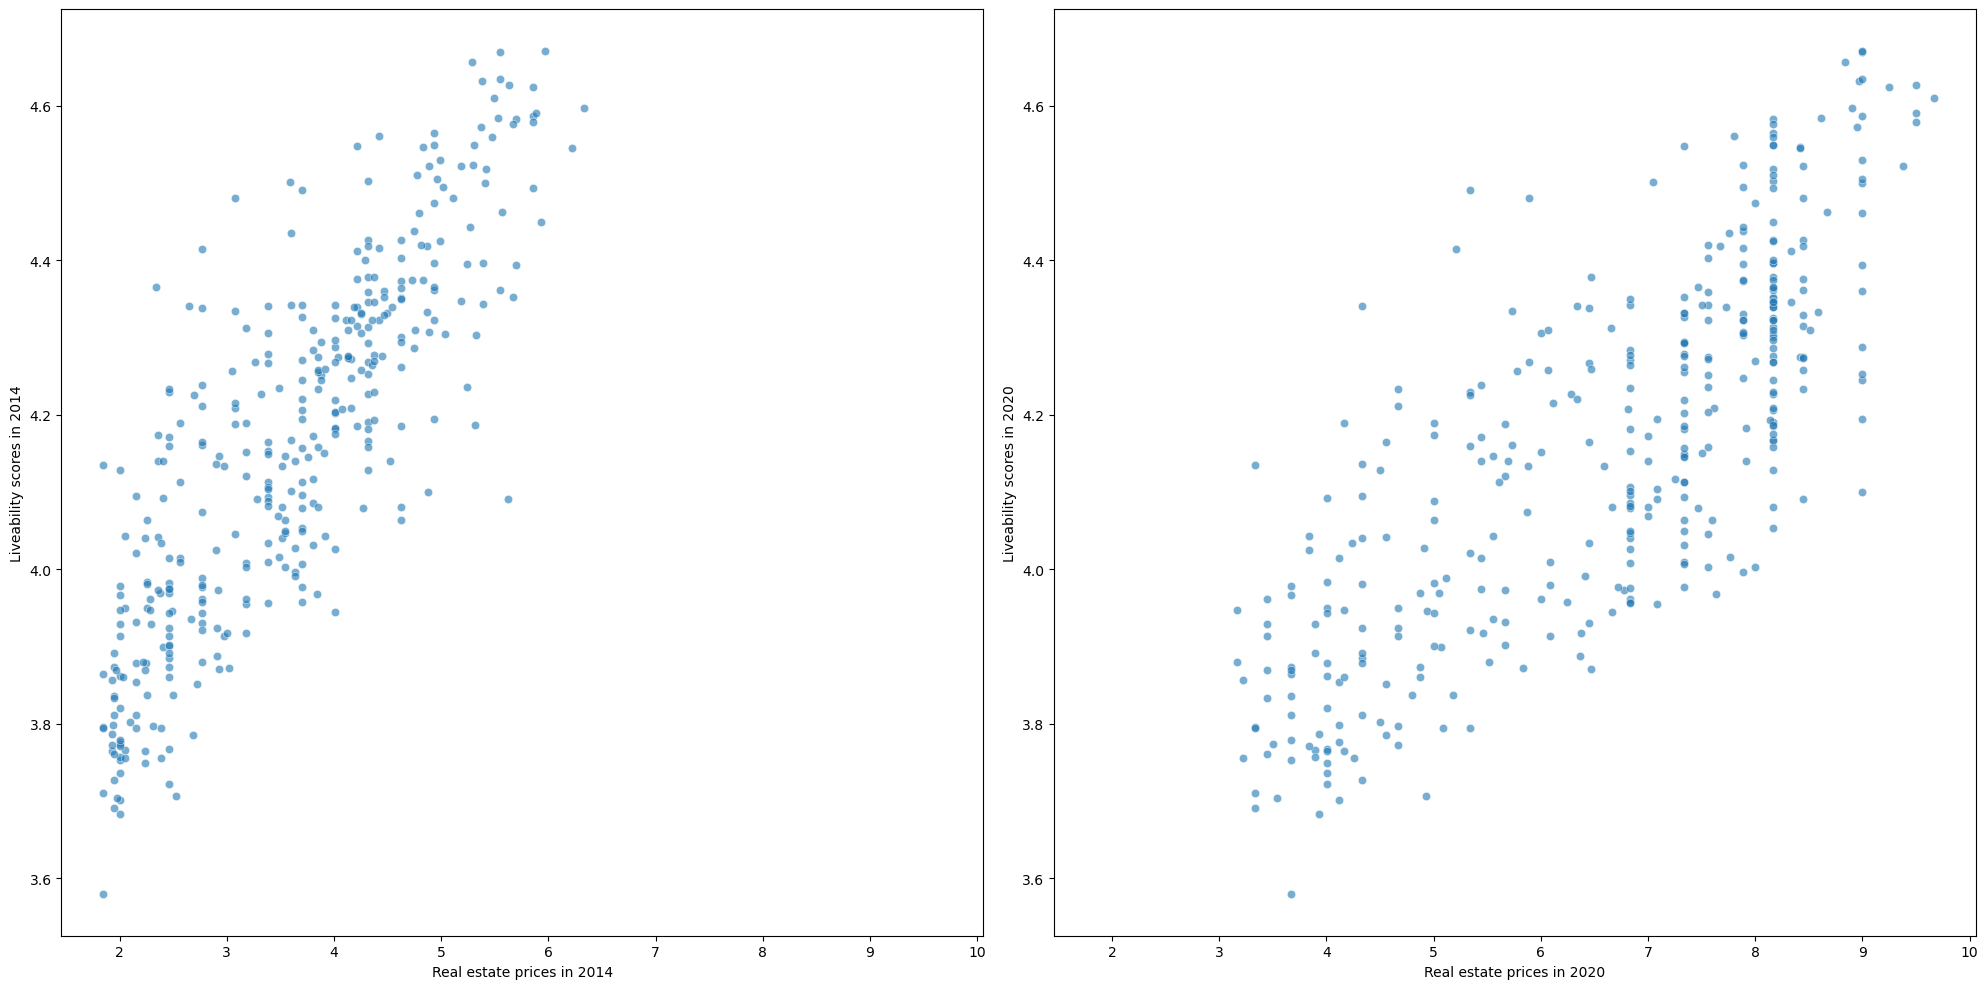

In [27]:
# Visualisation of the correlation between real-estate prices and liveability for both years using scatter plots
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True)
fig.set_tight_layout(True)
sns.scatterplot(ax = axes[0],x = buurt_2014_df.price_2014, y = buurt_2014_df.lbm, alpha = 0.6)
sns.scatterplot(ax = axes[1],x = buurt_2020_df.price_2020, y = buurt_2014_df.lbm, alpha = 0.6)

axes[0].set_xlabel('Real estate prices in 2014')
axes[0].set_ylabel('Liveability scores in 2014')
axes[1].set_xlabel('Real estate prices in 2020')
axes[1].set_ylabel('Liveability scores in 2020')

In [28]:
buurt_2014_df.head()

,bu_code,geometry,versie,jaar,bu_naam,lbm,afw,fys,onv,soc,vrz,won,price_2014,WK_CODE,GM_CODE,GM_NAAM,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,P_15_24_JR,P_25_44_JR,P_45_64_JR,P_65_EO_JR,P_WEST_AL,P_N_W_AL,P_MAROKKO,P_ANT_ARU,P_SURINAM,P_TURKIJE,P_OVER_NW,WONINGEN,P_1GEZW,P_MGEZW,P_BEWNDW,P_KOOPWON,P_HUURWON,P_HUURCORP,P_HUUROVVH,P_WONT2000,P_WONV2000,P_LEEGSW,WW_UIT_TOT,AUTO_HH,AV1_ARTSPR,AF_APOTH,AF_ZIEK_I,AV1_SUPERM,AV1_DAGLMD,AV1_CAFE,AF_WARENH,AV1_RESTAU,AF_HOTEL,AV1_KDV,AV1_BSO,AV1_ONDBAS,AF_ONDVRT,AF_ONDVMB,AF_ONDHV,AF_TREINST,AF_BIBLIO,AF_BIOS,AF_ATTRAC,AF_PODIUM,AF_MUSEUM
0,BU03630000,"POLYGON ((121890.334 487818.898, 121957.841 48...",Leefbaarometer 3.0,2014,Kop Zeedijk,4.342111,0.239846,0.005343,-0.185291,-0.063916,0.483296,0.000414,3.594333,WK036300,GM0363,Amsterdam,18119.0,1100.0,625.0,470.0,4.0,11.0,52.0,25.0,7.0,36.0,18.0,0.0,1.0,2.0,1.0,12.0,773.0,4.0,96.0,79.0,20.0,78.0,7.0,71.0,96.0,4.0,21.0,20.0,0.2,6.6,0.3,1.1,10.6,140.7,181.2,0.5,295.7,0.0,6.9,4.0,2.2,1.1,1.1,1.1,0.4,0.8,1.2,1.1,0.6,0.2
1,BU03630001,"POLYGON ((121585.791 487654.680, 121624.240 48...",Leefbaarometer 3.0,2014,Oude Kerk e.o.,4.313165,0.210901,0.004292,-0.241124,-0.064267,0.507547,0.004453,4.313000,WK036300,GM0363,Amsterdam,8272.0,730.0,410.0,315.0,4.0,18.0,51.0,18.0,9.0,34.0,17.0,1.0,1.0,2.0,1.0,13.0,534.0,5.0,95.0,78.0,12.0,85.0,27.0,59.0,87.0,13.0,22.0,20.0,0.2,8.6,0.3,0.8,11.0,154.4,202.7,0.3,330.2,0.1,6.3,3.1,1.8,1.3,1.3,1.3,0.7,1.2,1.0,1.1,0.4,0.2
2,BU03630002,"POLYGON ((121799.802 487534.283, 121824.012 48...",Leefbaarometer 3.0,2014,Burgwallen Oost,4.275189,0.172924,0.002242,-0.235697,-0.087144,0.498839,-0.005316,3.851000,WK036300,GM0363,Amsterdam,25867.0,1610.0,855.0,755.0,5.0,16.0,48.0,19.0,11.0,34.0,20.0,1.0,1.0,2.0,1.0,15.0,1001.0,4.0,96.0,85.0,17.0,82.0,9.0,74.0,96.0,4.0,15.0,40.0,0.2,7.5,0.2,0.9,12.0,143.8,204.7,0.4,330.4,0.1,6.9,3.0,2.0,1.4,1.4,1.4,0.8,1.1,0.9,0.8,0.3,0.2
3,BU03630003,"POLYGON ((121345.067 487317.970, 121365.571 48...",Leefbaarometer 3.0,2014,Nes e.o.,4.418488,0.316223,0.037115,-0.217396,-0.041720,0.538209,0.000016,4.867400,WK036300,GM0363,Amsterdam,6565.0,350.0,195.0,155.0,5.0,17.0,51.0,20.0,7.0,38.0,12.0,0.0,0.0,1.0,2.0,8.0,263.0,9.0,91.0,71.0,29.0,70.0,5.0,65.0,98.0,2.0,29.0,10.0,0.3,8.5,0.3,0.7,13.3,160.8,228.4,0.2,375.3,0.1,6.4,2.8,2.1,1.4,1.7,1.4,1.0,1.6,0.6,1.0,0.1,0.2
4,BU03630004,"POLYGON ((121557.295 487212.269, 121595.682 48...",Leefbaarometer 3.0,2014,BG-terrein e.o.,4.420118,0.317854,0.014476,-0.187590,-0.056868,0.527690,0.020145,4.813500,WK036300,GM0363,Amsterdam,7960.0,670.0,370.0,300.0,5.0,19.0,43.0,22.0,12.0,28.0,14.0,1.0,1.0,2.0,1.0,9.0,400.0,7.0,93.0,85.0,21.0,78.0,36.0,42.0,100.0,0.0,15.0,10.0,0.2,7.5,0.4,0.8,12.9,149.7,228.0,0.3,370.2,0.1,6.6,3.4,2.3,1.5,1.8,1.5,1.1,1.5,0.5,0.8,0.2,0.3


<AxesSubplot:>

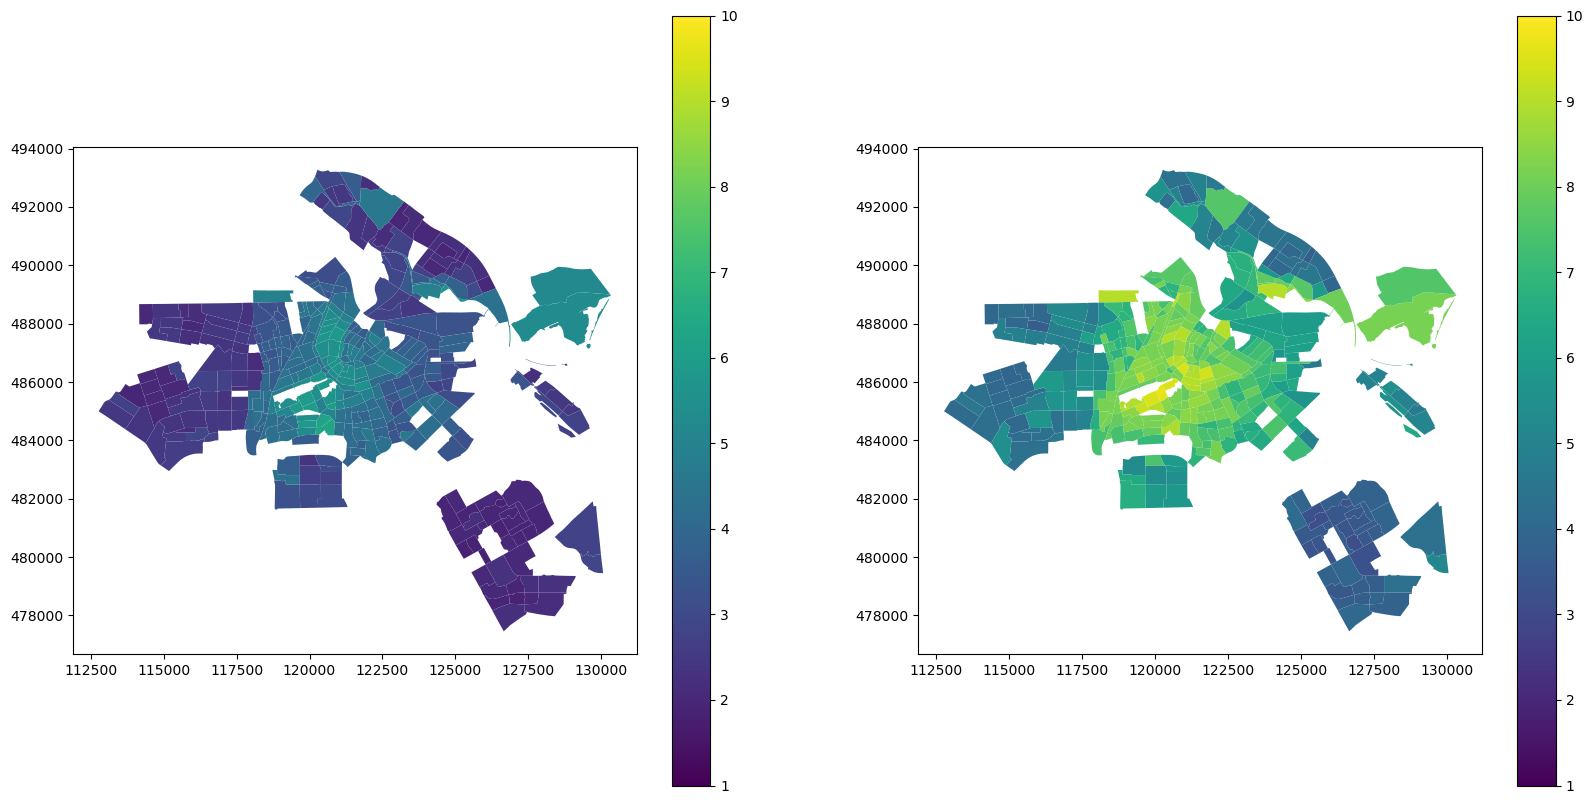

In [29]:
# Plot the real estate prices in Amsterdam at the buurt-level in 2014 and 2020 
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True)
buurt_2014_df.plot(ax=axes[0], column = 'price_2014', legend = True, vmin = 1, vmax = 10)
buurt_2020_df.plot(ax=axes[1], column = 'price_2020', legend = True, vmin = 1, vmax = 10)

<AxesSubplot:>

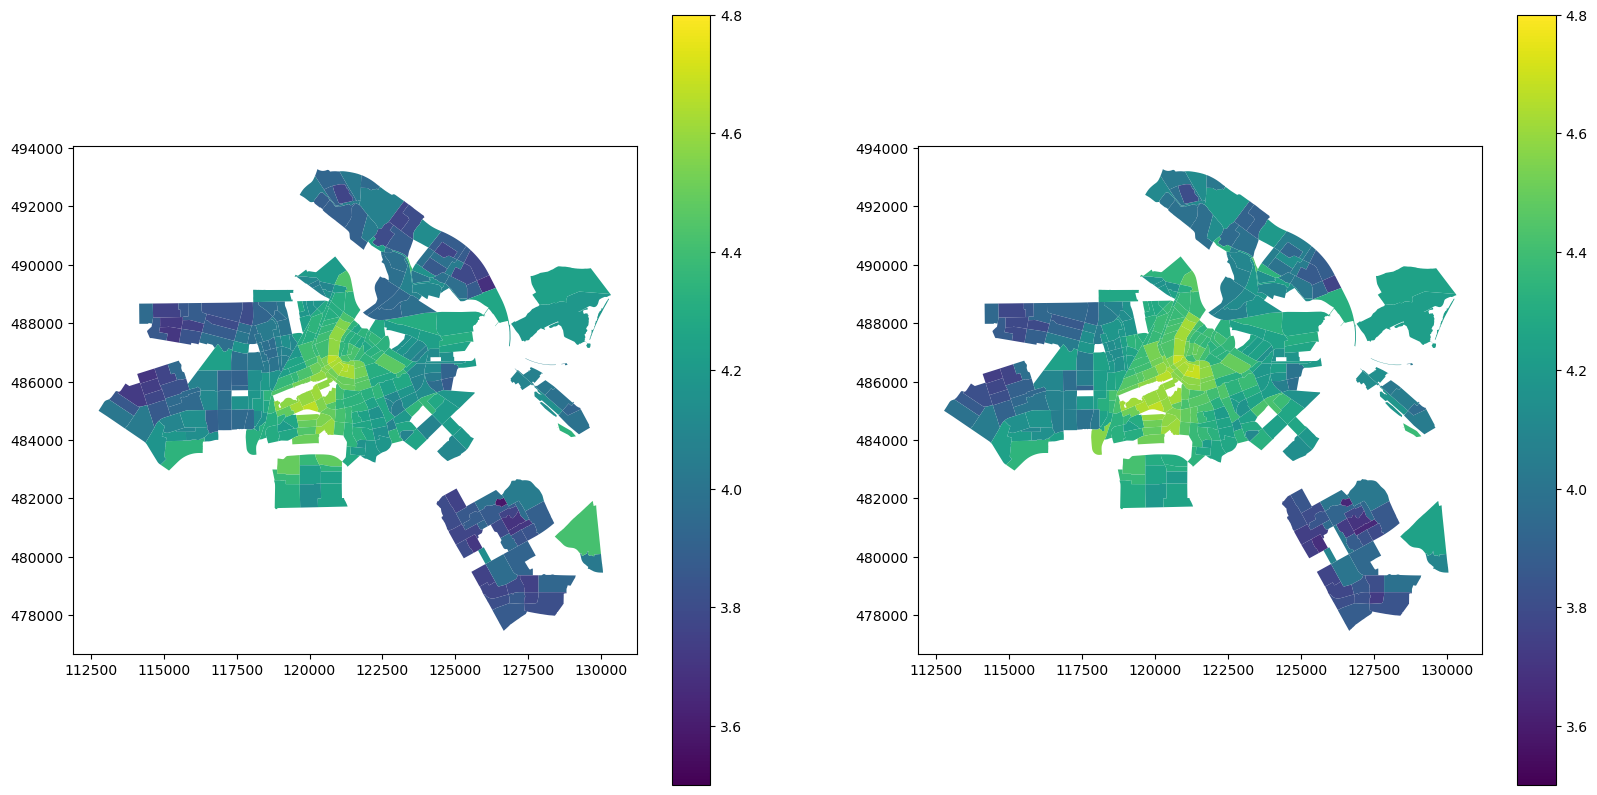

In [30]:
# Plot the real estate prices in Amsterdam at the buurt-level in 2014 and 2020 
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True)
buurt_2014_df.plot(ax=axes[0], column = 'lbm', legend = True, vmin = 3.5, vmax = 4.8)
buurt_2020_df.plot(ax=axes[1], column = 'lbm', legend = True, vmin = 3.5, vmax = 4.8)

### 3. Assess the change in affordability of liveable neighbourhoods [3 pnt]

#### 3.1 Explore how the change in liveability associates with a change in real-estate prices, using a scatter plot.

In [31]:
#rename some columns to prevent confusion when merging 
buurt_2014_df_lbm = buurt_2014_df.rename(columns={"lbm": "lbm_2014"})
buurt_2020_df_lbm = buurt_2020_df.rename(columns={"lbm": "lbm_2020"})

#create a dataframe with the lbm data and real estate prices of both years 
df_prices_lbm = buurt_2020_df_lbm[['bu_code','bu_naam','price_2020','lbm_2020']].merge(buurt_2014_df_lbm[['bu_code','price_2014','lbm_2014']], on ="bu_code", how = "inner")
df_prices_lbm['change_price'] = df_prices_lbm['price_2020']-df_prices_lbm['price_2014']
df_prices_lbm['change_lbm'] = df_prices_lbm['lbm_2020']-df_prices_lbm['lbm_2014']

df_prices_lbm.head()#check wheter the dataframe is generated correctly 

,bu_code,bu_naam,price_2020,lbm_2020,price_2014,lbm_2014,change_price,change_lbm
0,BU03630000,Kop Zeedijk,7.556500,4.389517,3.594333,4.342111,3.962167,0.047406
1,BU03630001,Oude Kerk e.o.,8.167375,4.379418,4.313000,4.313165,3.854375,0.066252
2,BU03630002,Burgwallen Oost,7.556500,4.357504,3.851000,4.275189,3.705500,0.082315
3,BU03630003,Nes e.o.,7.667400,4.497277,4.867400,4.418488,2.800000,0.078789
4,BU03630004,BG-terrein e.o.,7.556500,4.483628,4.813500,4.420118,2.743000,0.063510


Text(0, 0.5, 'Change in liveability between 2014 and 2020')

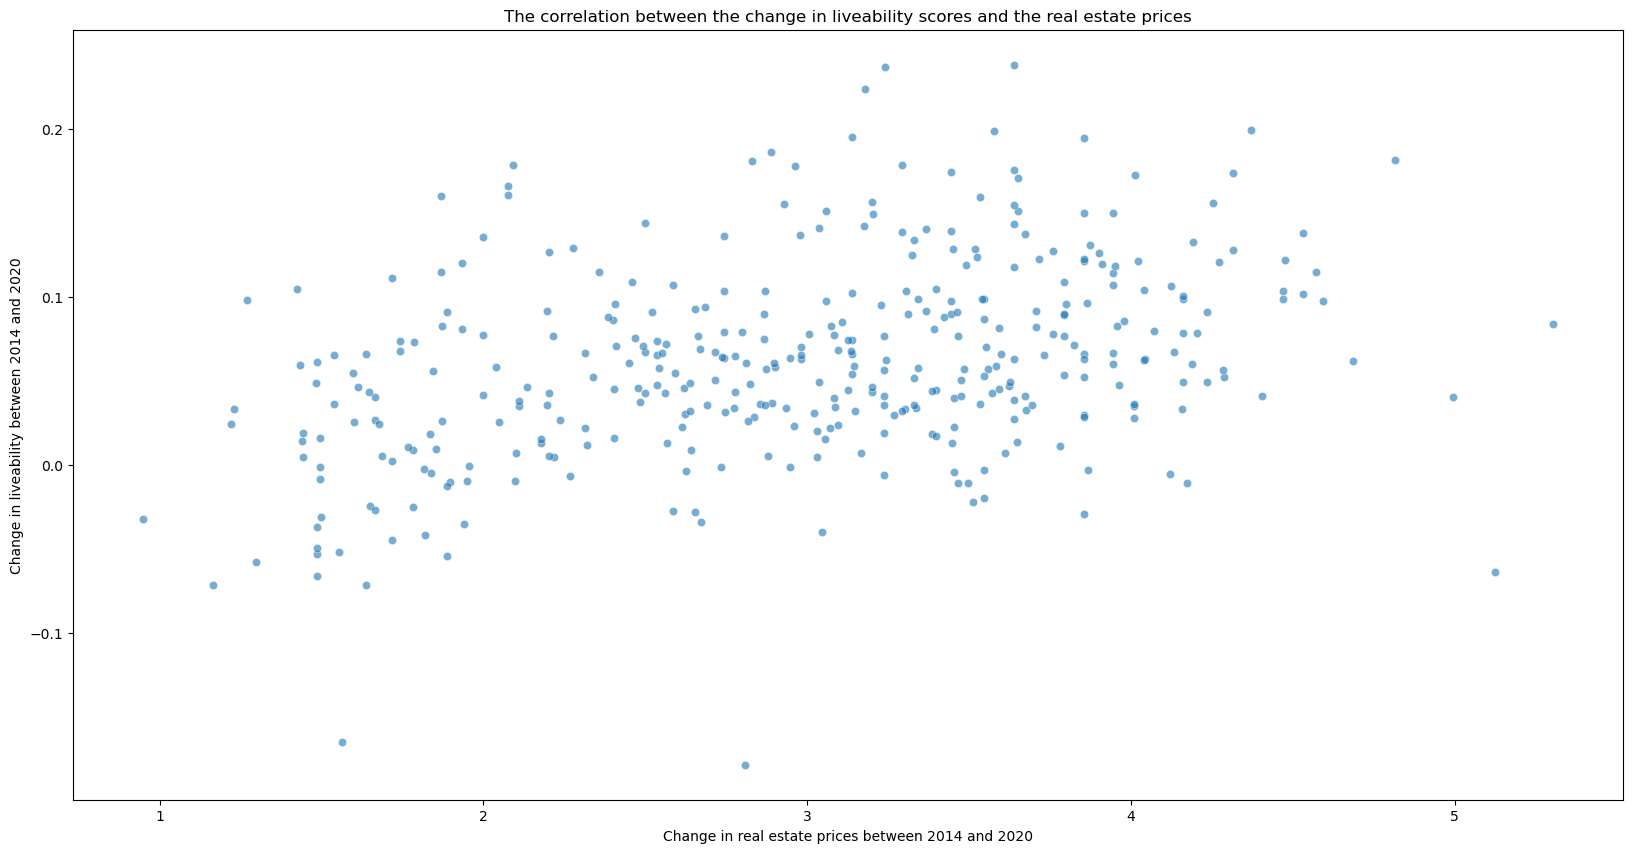

In [32]:
# Visualisation of the correlation between changes in real-estate prices and liveability using scatter plots
fig, ax = plt.subplots( figsize=(20, 10))
sns.scatterplot(ax = ax,x = df_prices_lbm.change_price, y = df_prices_lbm.change_lbm, alpha = 0.6)

ax.set_title('The correlation between the change in liveability scores and the real estate prices')
ax.set_xlabel('Change in real estate prices between 2014 and 2020')
ax.set_ylabel('Change in liveability between 2014 and 2020')

In [33]:
from scipy.stats.stats import pearsonr
print(pearsonr(df_prices_lbm.change_price, df_prices_lbm.change_lbm))

(0.37379856762772234, 5.576856715222932e-14)


The correlation between the change in liveability scores and the change in real estate prices is small. There is some correlation that can be seen, where a large (positive) change in price results in a higher (positive) change in liveability score, but this is not very large. This can also be seen from the calculation above. 

#### 3.2 Compute the ratio of the liveability score over the real-estate price for both years, and show how the distribution of the ratio of liveability over real-estate price has changed between the two years.

In [34]:
#Add columns to the dataframe with the ratio of liveability score over the real-estate price
df_prices_lbm['lbm_price_2014']= df_prices_lbm['lbm_2014']/df_prices_lbm['price_2014']
df_prices_lbm['lbm_price_2020']= df_prices_lbm['lbm_2020']/df_prices_lbm['price_2020']
df_prices_lbm.head()

,bu_code,bu_naam,price_2020,lbm_2020,price_2014,lbm_2014,change_price,change_lbm,lbm_price_2014,lbm_price_2020
0,BU03630000,Kop Zeedijk,7.556500,4.389517,3.594333,4.342111,3.962167,0.047406,1.208044,0.580893
1,BU03630001,Oude Kerk e.o.,8.167375,4.379418,4.313000,4.313165,3.854375,0.066252,1.000038,0.536209
2,BU03630002,Burgwallen Oost,7.556500,4.357504,3.851000,4.275189,3.705500,0.082315,1.110150,0.576656
3,BU03630003,Nes e.o.,7.667400,4.497277,4.867400,4.418488,2.800000,0.078789,0.907772,0.586545
4,BU03630004,BG-terrein e.o.,7.556500,4.483628,4.813500,4.420118,2.743000,0.063510,0.918275,0.593347


Text(0.5, 0, 'liveability over price levels 2020')

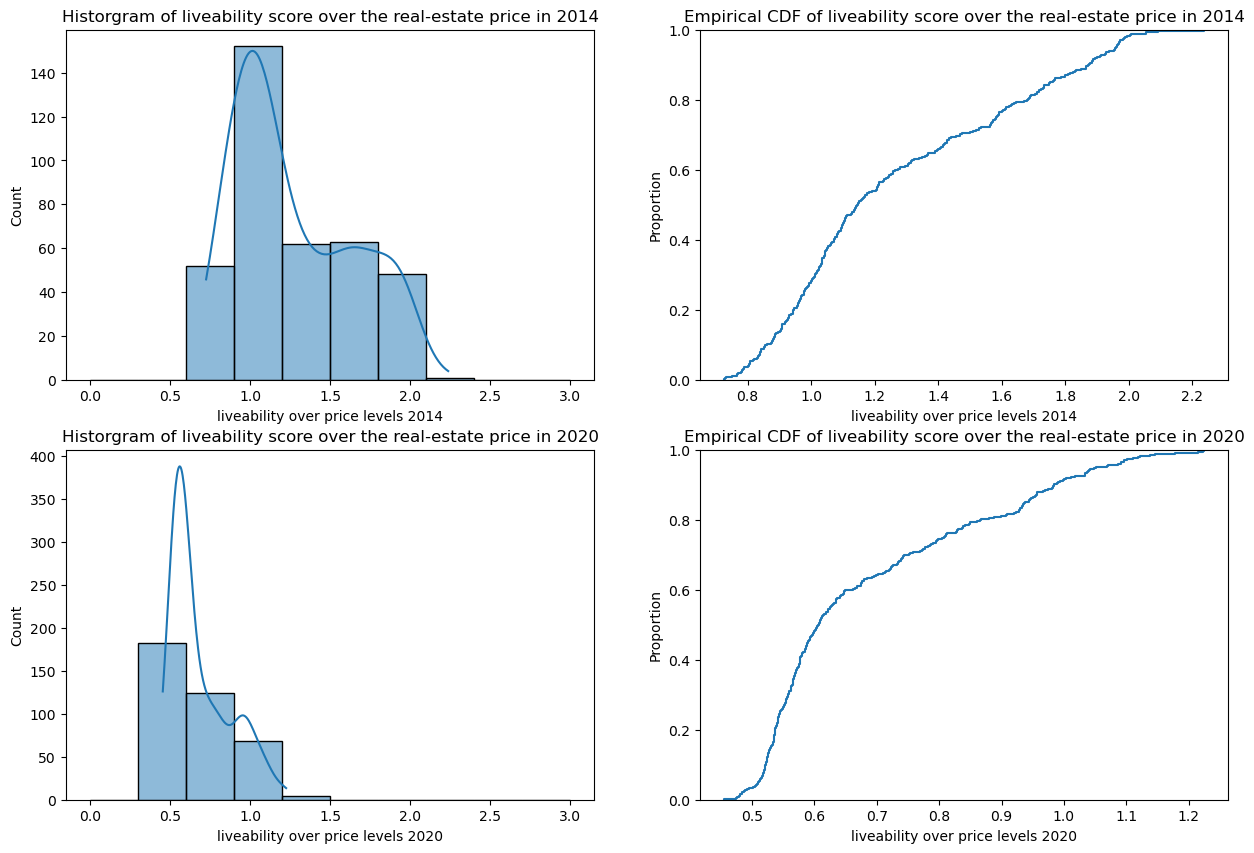

In [35]:
# Create histograms and empirical CDFs for 2014 and 2020 to compare the ratio of liveability score over the real-estate price
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=False)
sns.histplot(ax = axes[0,0],x = df_prices_lbm.lbm_price_2014, bins = 10, kde=True, binrange = (0,3))
sns.ecdfplot(ax = axes[0,1],x = df_prices_lbm.lbm_price_2014)
sns.histplot(ax = axes[1,0],x = df_prices_lbm.lbm_price_2020, bins = 10, kde=True, binrange = (0,3))
sns.ecdfplot(ax = axes[1,1],x = df_prices_lbm.lbm_price_2020)

axes[0,0].set_title("Historgram of liveability score over the real-estate price in 2014")
axes[0,0].set_xlabel("liveability over price levels 2014")
axes[0,1].set_title("Empirical CDF of liveability score over the real-estate price in 2014")
axes[0,1].set_xlabel("liveability over price levels 2014")
axes[1,0].set_title("Historgram of liveability score over the real-estate price in 2020")
axes[1,0].set_xlabel("liveability over price levels 2020")
axes[1,1].set_title("Empirical CDF of liveability score over the real-estate price in 2020")
axes[1,1].set_xlabel("liveability over price levels 2020")
#Note, the Empirical CDFs have a different x scale 

#### 3.3 Determine the 5 buurten in which the ratio of liveability over real-estate has deteriorated most.

In [36]:
#Add a column with the deterioration of the ratio of liveability over real estate prices 
df_prices_lbm['change_ratio']= df_prices_lbm['lbm_price_2020'] - df_prices_lbm['lbm_price_2014'] 

In [37]:
#Identify the 5 buurten where the change in the ratio is the most negative, thus has deteriorated the most
df_prices_lbm.nsmallest(5,'change_ratio')

,bu_code,bu_naam,price_2020,lbm_2020,price_2014,lbm_2014,change_price,change_lbm,lbm_price_2014,lbm_price_2020,change_ratio
101,BU03632303,Zuidas Zuid,7.467400,4.300641,2.341,4.364762,5.126400,-0.064120,1.864486,0.575922,-1.288564
317,BU03638604,Johan Jongkindbuurt,5.667833,3.909219,2.156,3.931194,3.511833,-0.021974,1.823374,0.689720,-1.133653
279,BU03637402,Elzenhagen Noord,4.501250,4.196138,2.002,4.128963,2.499250,0.067175,2.062419,0.932216,-1.130203
271,BU03637002,Banne Noordwest,4.667750,3.909032,1.925,3.772715,2.742750,0.136317,1.959852,0.837455,-1.122397
315,BU03638602,Rembrandtpark Noord,5.334500,4.244649,2.156,4.020687,3.178500,0.223962,1.864883,0.795698,-1.069185


The five buurten, from worst to least deteriorated, are Zuidas Zuid, Johan Jongkindbuurt, Elzenhagen Noord, Banne Noordwest and Rembrandtpark Noord. 

#### 3.4 Determine whether the number of buurten with price < 5k euro/m2 and a liveability ratio > 1/k euro has decreased in 2020, compared to 2014

In [38]:
# Create variables counting the number of buurten with a price < 5k euro/m2 and a liveability ratio > 1/k euro

buurten_price5_lbm1_2014 =sum((df_prices_lbm.price_2014<5) & (df_prices_lbm.lbm_2014 > 1))
buurten_price5_lbm1_2020 =sum((df_prices_lbm.price_2020<5) & (df_prices_lbm.lbm_2020 > 1))

print('The number of buurten with price < 5k euro/m2 and lbm >1k euro in 2014 is:', buurten_price5_lbm1_2014)
print('The number of buurten with price < 5k euro/m2 and lbm >1k euro in 2020 is:', buurten_price5_lbm1_2020)
print('The number of buurten with the criteria has decreased by',buurten_price5_lbm1_2014-buurten_price5_lbm1_2020)

The number of buurten with price < 5k euro/m2 and lbm >1k euro in 2014 is: 337
The number of buurten with price < 5k euro/m2 and lbm >1k euro in 2020 is: 90
The number of buurten with the criteria has decreased by 247


### 4. Qualitative reflection on machine learning and generalisation [1 pnt]

**Question: There are some buurts in Amsterdam for which real-estate price data were missing. Suppose the minicipality of Amsterdam asks you whether you can create a machine learning model that can predict real-estate prices from the liveability index. Do you think this is possible? Explain your answer (conceptually).**

Answer: Based on the analysis in this assignment I would argue it is difficult to construct a well performing machine learning model to predict the real-estate prices based on solely the liveability scores. As can be seen in the scatterplot from section 3.1, the change in liveability scores over the years doesn't correlate much with the real estate prices. This means that over the years, the link between the liveability scores and the real estate prices change. Without knowing in which year you are it is difficult to determine the relation between the two. 

The relation is also because the real estate prices have grown a lot. From the scatterplot in section 2.2, showing the correlation between the real estate prices and the liveability scores, it seems the liveability is higher in buurten with high real estate prices. However, a high price in 2014 can be low in 2020, which will interfere with the prediction for the liveability scores. Therefore, more information than solely the real estate price is needed. For example the average housing price in the area is of high influence. A machine learning model that can operate with more of such data could give an estimation of the liveability score. 

A benefit is that the ratio of missing values is small. It would be possible to create a ML model with test and train data. There is enough data to find out whether the real estate prices have a bigger influence than the other features and in such, how usefull it is to predict the liveability score of a buurt. 